In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import folium
import matplotlib.colors as mcolors

In [2]:
m = folium.Map([33.447046773463654, -112.08091337731709], zoom_start=5)

In [5]:
df = pd.read_csv('./../../CSVs/RAW/lithium-reciclying-plants.csv', delimiter=';')
df[['lon', 'lat']] = df['WKT'].str.extract(r'POINT \(([^ ]+) ([^)]+)\)').astype(float)
df

,WKT,name,description,lon,lat
0,POINT (-77.67829119999999 43.1981518),Li-Cycle New York Spoke,Expects to use a hydrometallurgical process an...,-77.678291,43.198152
1,POINT (-111.7696764 32.87824409999999),Quemetco Metals Ltd Inc,Quemetco Metals Ltd Inc - Ecobat. It will init...,-111.769676,32.878244
2,POINT (-95.46281119999999 29.7386312),ACE Green Recycling,https://www.acegreenrecycling.com/ It plans to...,-95.462811,29.738631
3,POINT (-119.7414856 39.204376),Redwood Materials,"Unspecified capacity, up to 95% material recov...",-119.741486,39.204376
4,POINT (-119.8217446 39.5242032),American Battery Technology Company,"https://americanbatterytechnology.com 20,000 t...",-119.821745,39.524203
5,POINT (-119.4399422 39.53570729999999),Tesla Giga Nevada,"Tesla Gigafactory 1, located in Sparks, Nevada...",-119.439942,39.535707
6,POINT (-83.84230749999999 33.6122481),Ascend Elements,"""Inc.,Unspecified capacity, recycling process...",-83.842307,33.612248


In [6]:
rad_lat = np.radians(df['lat'])
rad_lon = np.radians(df['lon'])

df['x'] = np.cos(rad_lat) * np.cos(rad_lon)
df['y'] = np.cos(rad_lat) * np.sin(rad_lon)
df['z'] = np.sin(rad_lat)

In [7]:
X = df[['x', 'y', 'z']]

In [9]:
k_values = range(2, 5)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, cluster_labels))

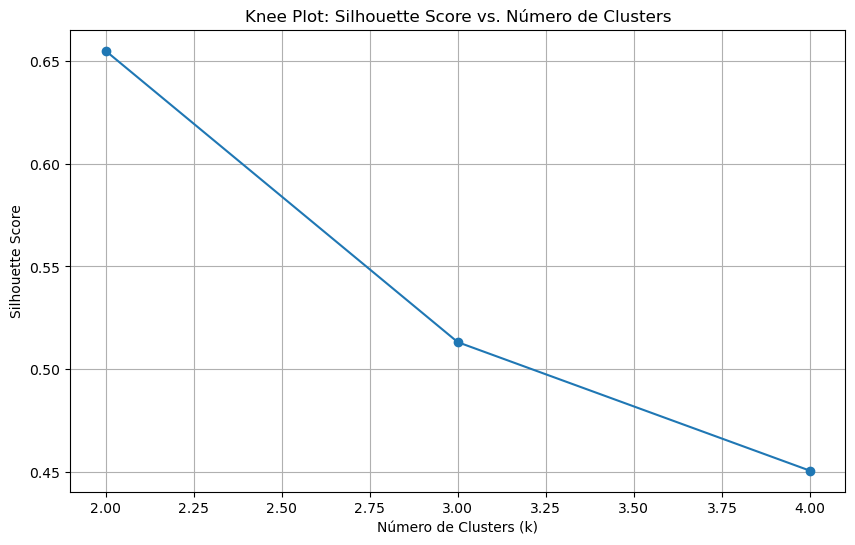

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Knee Plot: Silhouette Score vs. Número de Clusters')
plt.grid(True)
plt.show()

In [11]:
k=3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)
sil_score = silhouette_score(X, cluster_labels)
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: 0.5131


In [12]:
df['cluster'] = cluster_labels
df

,WKT,name,description,lon,lat,x,y,z,cluster
0,POINT (-77.67829119999999 43.1981518),Li-Cycle New York Spoke,Expects to use a hydrometallurgical process an...,-77.678291,43.198152,0.155567,-0.712198,0.684524,2
1,POINT (-111.7696764 32.87824409999999),Quemetco Metals Ltd Inc,Quemetco Metals Ltd Inc - Ecobat. It will init...,-111.769676,32.878244,-0.311472,-0.779932,0.542856,1
2,POINT (-95.46281119999999 29.7386312),ACE Green Recycling,https://www.acegreenrecycling.com/ It plans to...,-95.462811,29.738631,-0.082662,-0.864354,0.496044,0
3,POINT (-119.7414856 39.204376),Redwood Materials,"Unspecified capacity, up to 95% material recov...",-119.741486,39.204376,-0.384416,-0.672821,0.632088,1
4,POINT (-119.8217446 39.5242032),American Battery Technology Company,"https://americanbatterytechnology.com 20,000 t...",-119.821745,39.524203,-0.383598,-0.669210,0.636404,1
5,POINT (-119.4399422 39.53570729999999),Tesla Giga Nevada,"Tesla Gigafactory 1, located in Sparks, Nevada...",-119.439942,39.535707,-0.379067,-0.671640,0.636559,1
6,POINT (-83.84230749999999 33.6122481),Ascend Elements,"""Inc.,Unspecified capacity, recycling process...",-83.842307,33.612248,0.089331,-0.827998,0.553570,0


In [13]:
centroids = kmeans.cluster_centers_

centroids_lat = np.degrees(np.arcsin(centroids[:, 2]))
centroids_lon = np.degrees(np.arctan2(centroids[:, 1], centroids[:, 0]))

centroids_df = pd.DataFrame({'cluster': range(k), 'lat': centroids_lat, 'lon': centroids_lon})

print(centroids_df)

   cluster        lat         lon
0        0  31.655245  -89.774210
1        1  37.732576 -117.569261
2        2  43.198152  -77.678291


In [14]:
unique_clusters = np.unique(cluster_labels)

colors = [plt.cm.viridis(i / (len(unique_clusters) - 1)) for i in range(len(unique_clusters))]

cluster_colors = {cluster: mcolors.to_hex(colors[i]) for i, cluster in enumerate(unique_clusters)}

df['color'] = df['cluster'].map(cluster_colors)

In [15]:
def mark_on_map(row):
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        color=row['color'],
        fill=True,
        fill_color=row['color'],
        fill_opacity=0.7,
        popup=f"Cluster: {row['cluster']}"
    ).add_to(m)

df.apply(mark_on_map, axis=1)

m

In [16]:
def mark_centroids(row):
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=f"Centroid Cluster {row['cluster']}",
        icon=folium.Icon(color="red", icon="info-sign")
    ).add_to(m)

centroids_df.apply(mark_centroids, axis=1)
m

In [ ]:
df.to_csv('./../../CSVs/Geographical/GEOGRAPHICAL lithium-reciclying-plants.csv', index=False)